# 순환 신경망(Recurrent Neural Network, RNN)

- 루프(loop)를 가진 신경망의 한 종류

- 시퀀스의 원소를 순회하면서 지금까지 처리한 정보를 상태(state)에 저장

<img src="https://miro.medium.com/max/627/1*go8PHsPNbbV6qRiwpUQ5BQ.png">

<sub>출처: https://towardsdatascience.com/understanding-rnn-and-lstm-f7cdf6dfc14e</sub>

<br>

<br>

## 순환 신경망 레이어 (RNN Layer)

- 입력: `(timesteps, input_features)`

- 출력: `(timesteps, output_features)`

In [1]:
import numpy as np

In [2]:
timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))

state_t = np.zeros((output_features, ))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features, ))

successive_outputs = []

for input_t in inputs:
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  successive_outputs.append(output_t)

  state_t = output_t

final_output_sequence = np.stack(successive_outputs, axis=0)

<br>

<br>

## 케라스의 순환층
- `SimpleRNN` layer

- 입력: `(batch_size, timesteps, input_features)`



<br>

#### `tensorflow.keras.layers.SimpleRNN(units, activation, use_bias, kernel_initializer, return_sequences, ...)`

- `return_sequences` : `True`일 시,
  - **3D 텐서**
    - **타임스텝의 출력을 모은 전체 시퀀스를 반환**

    - `(batch_size, timesteps, output_features)`

  - **2D 텐서**
    - **입력 시퀀스에 대한 마지막 출력만 반환**

    - `(batch_size, output_features)`
  - **`False`는 마지막 순환신경층에만 사용**

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Embedding
from tensorflow.keras.models import Model, Sequential

In [7]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


<br>

- `return_sequences` = `True`

In [8]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


<br>

- **네트워크의 표현력을 증가시키기 위해 여러 개의 순환층을 차례대로 쌓는 것이 유용할 때가 있음**
  - 이런 설정에서는 중간층들이 전체 출력 시퀀스를 반환하도록 설정

In [9]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=False))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


<br>

<br>

## IMDB 데이터 적용

<br>

### 데이터 로드

In [21]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

In [23]:
num_words = 10000
max_len = 500
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=num_words)
print(len(input_train))
print(len(input_test))

input_train = sequence.pad_sequences(input_train, maxlen=max_len)
input_test = sequence.pad_sequences(input_test, maxlen=max_len)
print(input_train.shape)
print(input_test.shape)

25000
25000
(25000, 500)
(25000, 500)


<br>


### 모델 구성

In [24]:
from tensorflow.keras.layers import Dense

In [25]:
model = Sequential()

model.add(Embedding(num_words, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


<br>

### 모델 학습

In [26]:
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2, verbose=False)

<br>

### 시각화

In [12]:
import matplotlib.pyplot as plt

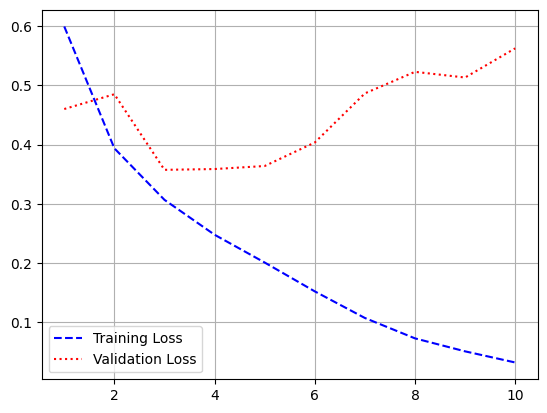

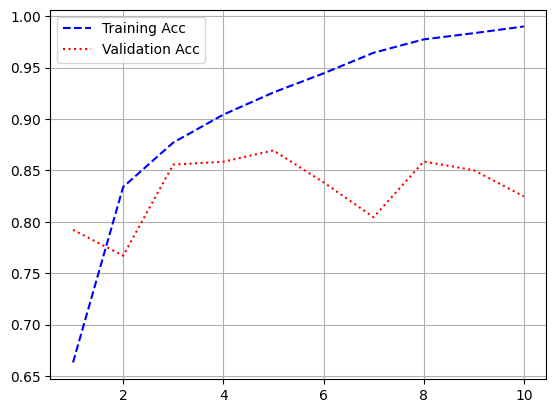

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b--', label='Training Loss')
plt.plot(epochs, val_loss, 'r:', label='Validation Loss')
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Training Acc')
plt.plot(epochs, val_acc, 'r:', label='Validation Acc')
plt.grid()
plt.legend()
plt.show()

In [29]:
model.evaluate(input_test, y_test)

782/782 [==============================] - 33s 43ms/step - loss: 0.5880 - acc: 0.8229


[0.5880300402641296, 0.822920024394989]

- 전체 시퀀스가 아니라 순서대로 500개의 단어만 입력했기 때문에 성능이 낮게 나옴

- **SimpleRNN은 긴 시퀀스를 처리하는데 적합하지 않음**

<br>

<br>

<br>

# LSTM과 GRU 레이어

- SimpleRNN은 실전에 사용하기엔 너무 단순

- **SimpleRNN은 이론적으로 시간 $t$ 에서 이전의 모든 타임스텝의 정보를 유지할 수 있지만, 실제로는 긴 시간에 걸친 의존성은 학습할 수 없음**

- **그래디언트 소실 문제(vanishing gradient problem)**
  - 이를 방지하기 위해 LSTM, GRU 같은 레이어 등장



<br>

<br>

## LSTM(Long Short-Term Memory)
- 장단기 메모리 알고리즘

- 나중을 위해 정보를 저장함으로써 오래된 시그널이 점차 소실되는 것을 막아줌

  <img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png">

  <sub>출처: https://colah.github.io/posts/2015-08-Understanding-LSTMs/</sub>

<br>

<br>

## 예제로 보는 순환 신경망: Reuters 

- IMDB와 유사한 데이터셋(텍스트 데이터)

- 46개의 상호 배타적인 토픽으로 이루어진 데이터셋 
  - 다중 분류 문제


<br>

### 데이터셋 로드

In [30]:
from tensorflow.keras.datasets import reuters

In [32]:
num_words = 10000
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

2110848/2110848 [==============================] - 1s 1us/step
(8982,)
(8982,)
(2246,)
(2246,)


<br>

### 데이터 전처리 및 확인

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
max_len = 500

In [39]:
pad_x_train = pad_sequences(x_train, maxlen=max_len)
pad_x_test = pad_sequences(x_test, maxlen=max_len)

print(len(x_train[0]))

87


<br>

### 모델 구성
- LSTM 레이어도 SimpleRNN과 같이 `return_sequences` 인자 사용가능

<br>

#### `tensorflow.keras.layers.LSTM(units, activation, use_bias, kernel_initializer, return_sequences, ...)`

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

In [43]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=64))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(46, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 64)          640000    
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 46)                1518      
                                                                 
Total params: 686,958
Trainable params: 686,958
Non-trainable params: 0
_________________________________________________________________


<br>

### 모델 학습

In [44]:
history = model.fit(pad_x_train, y_train,
                    batch_size=32, epochs=20,
                    validation_split=0.2, verbose=False)

<br>

### 시각화

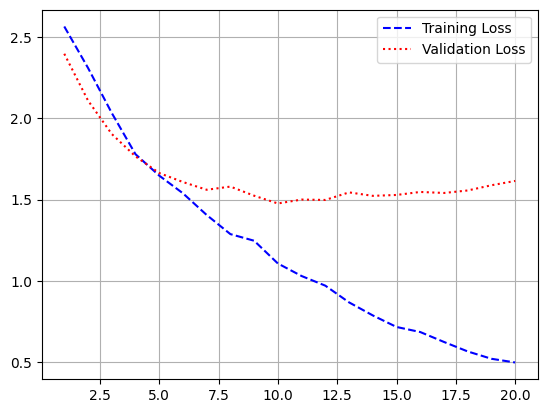

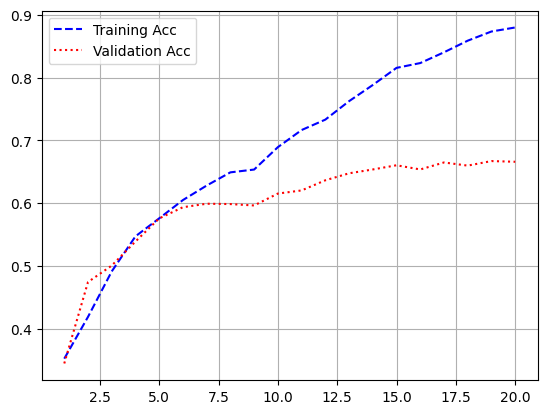

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b--', label='Training Loss')
plt.plot(epochs, val_loss, 'r:', label='Validation Loss')
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Training Acc')
plt.plot(epochs, val_acc, 'r:', label='Validation Acc')
plt.grid()
plt.legend()
plt.show()

<br>

### 모델 평가


In [46]:
model.evaluate(pad_x_test, y_test)

71/71 [==============================] - 1s 13ms/step - loss: 1.7563 - acc: 0.6376


[1.7562901973724365, 0.6375778913497925]

<br>

<br>

## IMDB 데이터셋 with LSTM

<br>

### 데이터 로드

In [6]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
num_words = 10000
max_len = 500
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=num_words)
print(len(input_train))
print(len(input_test))

input_train = pad_sequences(input_train, maxlen=max_len)
input_test = pad_sequences(input_test, maxlen=max_len)
print(input_train.shape)
print(input_test.shape)

25000
25000
(25000, 500)
(25000, 500)


<br>

### 모델 구성

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding

In [9]:
model = Sequential()

model.add(Embedding(num_words, 32))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


<br>

### 모델 학습

In [10]:
history = model.fit(input_train, y_train,
                    epochs=10, batch_size=28,
                    validation_split=0.2, verbose=False)

<br>

### 시각화

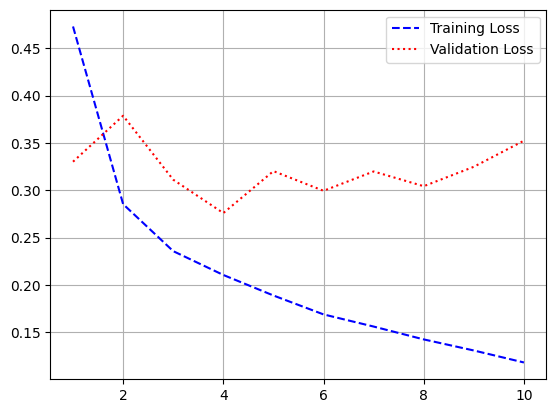

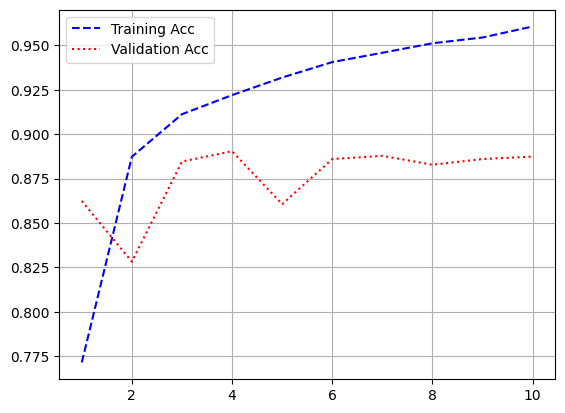

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b--', label='Training Loss')
plt.plot(epochs, val_loss, 'r:', label='Validation Loss')
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Training Acc')
plt.plot(epochs, val_acc, 'r:', label='Validation Acc')
plt.grid()
plt.legend()
plt.show()

<br>

### 모델 평가

In [14]:
model.evaluate(input_test, y_test)

782/782 [==============================] - 6s 8ms/step - loss: 0.3823 - acc: 0.8763


[0.38232916593551636, 0.8763200044631958]

<br>

<br>

<br>

# Cosine 함수를 이용한 순환 신경망

- 임의의 시계열 데이터 생성

In [46]:
import numpy as np

In [47]:
np.random.seed(111)

time = np.arange(30*12+1)
month_time = (time % 30) / 30
time_series = 20 * np.where(month_time < 0.5,
                            np.cos(2 * np.pi * month_time),
                            np.cos(2 * np.pi * month_time) + np.random.random(361))

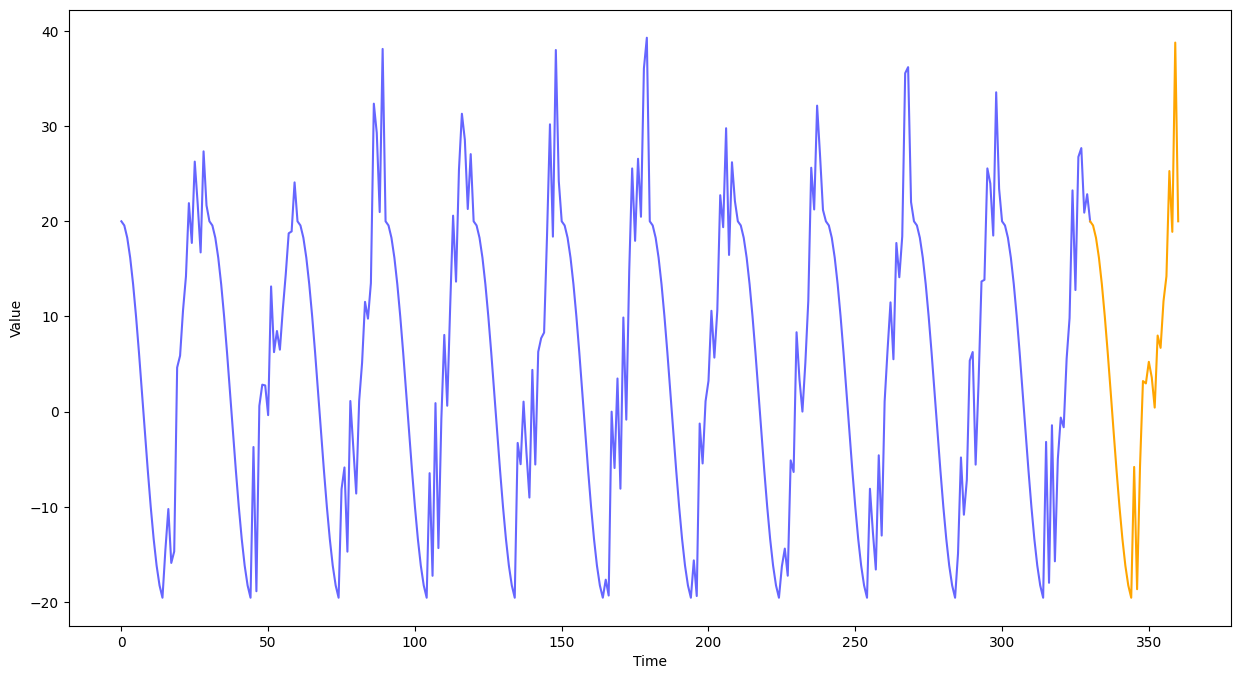

In [48]:
plt.figure(figsize=(15, 8))
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(np.arange(0, 30*11+1),
         time_series[:30*11+1],
         color='blue', alpha=0.6, label='Train Data')
plt.plot(np.arange(30*11, 30*12+1),
         time_series[30*11:],
         color='orange', label='Test Data')
plt.show()

<br>

### 데이터 전처리

- 시계열 데이터 생성 함수

In [49]:
def make_data(time_series, n):
  x_train_full, y_train_full = list(), list()

  for i in range(len(time_series)):
    x = time_series[i:(i+n)]
    
    if (i+n) < len(time_series):
      x_train_full.append(x)
      y_train_full.append(time_series[i+n])
    else:
      break

  x_train_full, y_train_full = np.array(x_train_full), np.array(y_train_full)

  return x_train_full, y_train_full

In [50]:
n = 10
x_train_full, y_train_full = make_data(time_series, n)

In [51]:
print(x_train_full.shape)
print(y_train_full.shape)

(351, 10)
(351,)


In [52]:
x_train_full = x_train_full.reshape(-1, n, 1)
y_train_full = y_train_full.reshape(-1, 1)

In [53]:
print(x_train_full.shape)
print(y_train_full.shape)

(351, 10, 1)
(351, 1)


<br>

<br>

## 테스트 데이터셋 생성

In [65]:
x_train = x_train_full[:30*11]
y_train = y_train_full[:30*11]

x_test = x_train_full[30*11:]
y_test = y_train_full[30*11:]

In [66]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(330, 10, 1)
(330, 1)
(21, 10, 1)
(21, 1)


<br>

<br>

## 데이터 확인

In [67]:
sample_series = np.arange(100)
a, b = make_data(sample_series, 10)

print(a[0])
print(b[0])

[0 1 2 3 4 5 6 7 8 9]
10


<br>

<br>

## 모델 구성

In [68]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense
from tensorflow.keras.models import Sequential

In [87]:
def build_model(n):
  model = Sequential()

  model.add(SimpleRNN(units=32, activation='tanh', input_shape=(n, 1)))
  model.add(Dense(1))

  model.compile(optimizer='adam', loss='mse')

  return model

In [88]:
model = build_model(10)

<br>

<br>

## 모델 학습

In [89]:
model.fit(x_train, y_train,
          epochs=100, batch_size=12,
          verbose=False)

<br>

<br>


## 예측값 그려보기

1/1 [==============================] - 0s 120ms/step


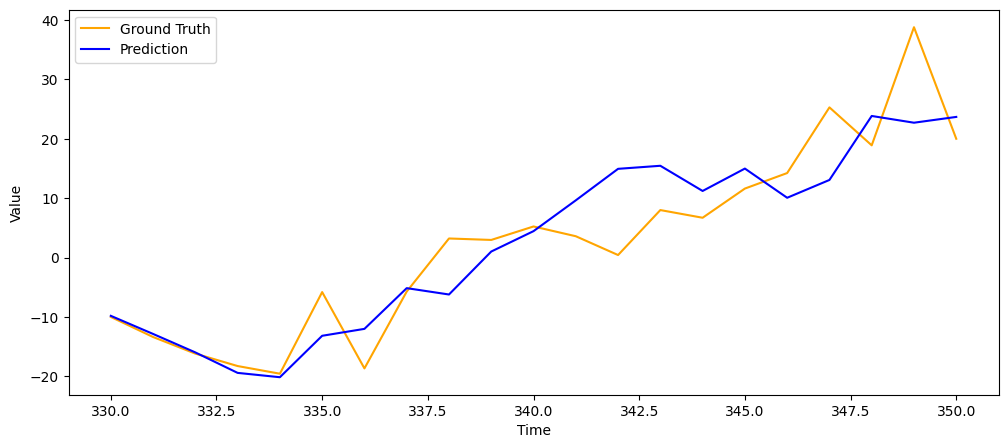

In [90]:
prediction = model.predict(x_test)

pred_range = np.arange(len(y_train), len(y_train) + len(prediction))

plt.figure(figsize=(12, 5))
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(pred_range, y_test.flatten(), color='orange', label='Ground Truth')
plt.plot(pred_range, prediction.flatten(), color='blue', label='Prediction')
plt.legend()
plt.show()

<br>

<br>

## 모델 재구성 (2)
- LSTM 사용

In [91]:
from tensorflow.keras.layers import LSTM

In [92]:
def build_model2(n):
  model = Sequential()

  model.add(LSTM(units=64, return_sequences=True, input_shape=(n, 1)))
  model.add(LSTM(units=32))
  model.add(Dense(1))

  model.compile(optimizer='adam', loss='mse')

  return model

In [93]:
model_2 = build_model2(10)

model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 10, 64)            16896     
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


<br>

<br>

## 모델 재학습 및 예측값 그려보기

In [94]:
model_2.fit(x_train, y_train,
            epochs=100, batch_size=12, verbose=False)

1/1 [==============================] - 0s 22ms/step


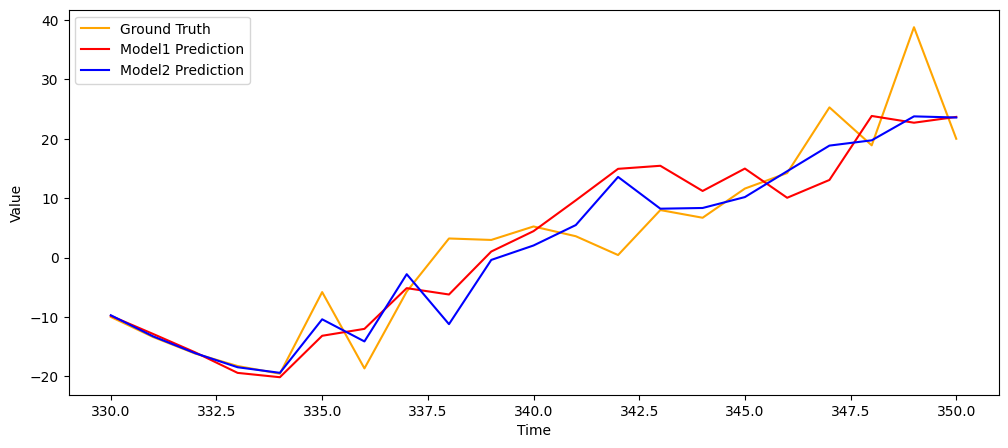

In [105]:
prediction2 = model_2.predict(x_test)

pred_range = np.arange(len(y_train), len(y_train) + len(prediction2))

plt.figure(figsize=(12, 5))
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(pred_range, y_test.flatten(), color='orange', label='Ground Truth')
plt.plot(pred_range, prediction.flatten(), color='red', label='Model1 Prediction')
plt.plot(pred_range, prediction2.flatten(), color='blue', label='Model2 Prediction')
plt.legend()
plt.show()

<br>

<br>


## 모델 재구성(3)
- GRU 사용
  - **LSTM 보다 더 쉬운 구조**

<br>

#### `tensorflow.keras.models.layers.GRU(units, activation, use_bias, kernel_initializer, return_sequences, ...)`

In [100]:
from tensorflow.keras.layers import GRU

In [101]:
def build_model3(n):
  model = Sequential()

  model.add(GRU(units=64, return_sequences=True, input_shape=(n, 1)))
  model.add(GRU(units=32))
  model.add(Dense(1))

  model.compile(optimizer='adam', loss='mse')

  return model

In [102]:
model_3 = build_model3(10)

<br>

<br>

## 모델 재학습 및 예측값 그려보기

In [103]:
model_3.fit(x_train, y_train,
            epochs=100, batch_size=12, verbose=False)

1/1 [==============================] - 0s 26ms/step


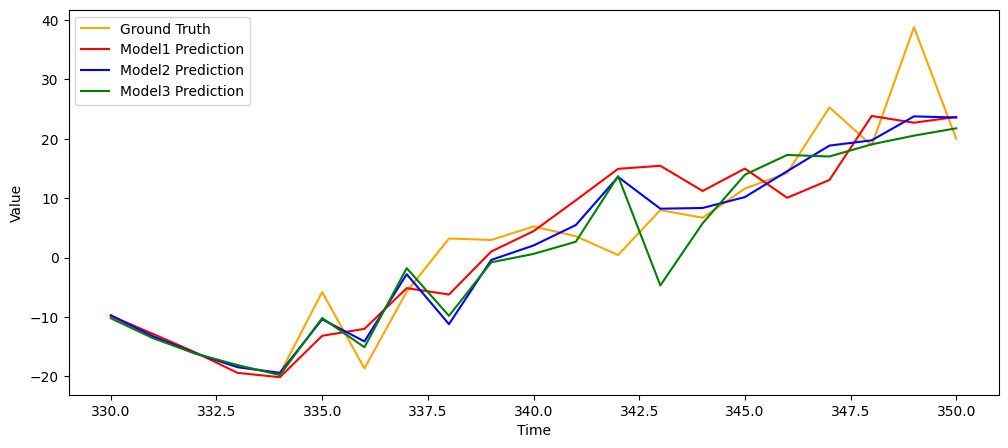

In [106]:
prediction3 = model_3.predict(x_test)

pred_range = np.arange(len(y_train), len(y_train) + len(prediction2))

plt.figure(figsize=(12, 5))
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(pred_range, y_test.flatten(), color='orange', label='Ground Truth')
plt.plot(pred_range, prediction.flatten(), color='red', label='Model1 Prediction')
plt.plot(pred_range, prediction2.flatten(), color='blue', label='Model2 Prediction')
plt.plot(pred_range, prediction3.flatten(), color='green', label='Model3 Prediction')
plt.legend()
plt.show()

<br>

<br>

<br>

# Conv1D 

- 텍스트 분류나 시계열 예측 같은 간단한 문제, 오디오 생성, 기계 번역 등의 문제에서 좋은 성능
- **글을 그림처럼 보는 Convolutional Neural Network (CNN)**

- **타임스텝의 순서에 민감하지 않음**


- **2D Convolution**
  - **지역적 특징을 인식**

  <img src="https://jiho-ml.com/content/images/2020/07/2D-convolutional-example_2x-700x584.png" width="500">

- 1D Convolution
  - **문맥을 인식**

  <img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FF2bI1%2FbtqJSciC5nJ%2FstSwF20OKLLuCSzvVz68fk%2Fimg.png" width="500">

  <sub>출처: https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/</sub>

<br>

<br>

## Conv1D Layer
- 입력: `(batch_size, timesteps, channels)`

- 출력: `(batch_size, timesteps, filters)`

- 필터의 사이즈가 커져도 모델이 급격히 증가하지 않기 때문에 다양한 크기를 사용할 수 있음
- 데이터의 품질이 좋으면 굳이 크기를 달리하여 여러 개를 사용하지 않아도 될 수도 있음

<br>

<br>

## MaxPooling1D Layer
- 다운 샘플링 효과

- 단지 1차원형태로 바뀐 것 뿐

<br>

<br>

## GlovalMaxPooling Layer
- 배치차원을 제외하고 2차원 형태를 1차원 형태로 바꾸어주는 레이어

- Flatten layer로 대신 사용가능

<br>

<br>

## IMDB 데이터셋

<br>

### 데이터 로드 및 전처리

In [3]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import RMSprop

In [4]:
num_words = 10000
max_len = 500
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=num_words)

print(len(input_train))
print(len(input_test))

25000
25000


In [5]:
pad_x_train = pad_sequences(input_train, maxlen=max_len)
pad_x_test = pad_sequences(input_test, maxlen=max_len)

<br>

### 모델 구성

In [6]:
def build_model():
  model = Sequential()

  model.add(Embedding(input_dim=num_words, output_dim=32,
                      input_length=max_len))
  model.add(Conv1D(32, 7, activation='relu'))
  model.add(MaxPooling1D(7))
  model.add(Conv1D(32, 5, activation='relu'))
  model.add(MaxPooling1D(5))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=RMSprop(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics=['acc'])
  
  return model

In [7]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           7200      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 70, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 66, 32)            5152      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 32)           0         
 1D)                                                             
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0

<br>

### 모델 학습

In [8]:
history = model.fit(pad_x_train, y_train,
                    epochs=30, batch_size=128,
                    validation_split=0.2, verbose=False)

<br>

### 시각화

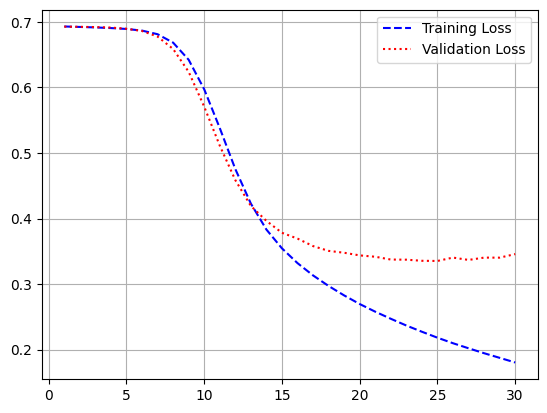

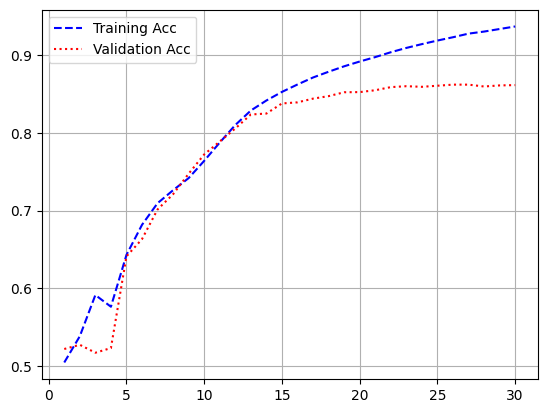

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b--', label='Training Loss')
plt.plot(epochs, val_loss, 'r:', label='Validation Loss')
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Training Acc')
plt.plot(epochs, val_acc, 'r:', label='Validation Acc')
plt.grid()
plt.legend()
plt.show()

- 과적합이 일어났지만, 다른 옵티마이저 사용, 규제화를 걸어보는 등 다양하게 시도해볼 수 있음